# Exploratory Analysis

What are people talking about?

In [1]:
from utils import DTYPE, PARSE_DATES, PROVINCES, CONVERTERS
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import glob

data_paths = glob.glob("../data/processed_data/*.csv")
frames = [pd.read_csv(f,header=0,dtype=DTYPE,converters=CONVERTERS,parse_dates=PARSE_DATES) for f in tqdm(data_paths)]
total_df = pd.concat(frames, axis=0, ignore_index=True).set_index("id").sort_values("created_at")
total_df = total_df[~total_df.index.duplicated()]

total_df["created_at"] = total_df["created_at"].dt.to_period("D").dt.to_timestamp('s')
print(len(total_df))
total_df.head()


349798


/Users/cameron/.local/share/virtualenvs/COVID-Child-Care-Twitter-vC7O4c45/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


created_at      screen_name              source  \
id                                                                    
1228469111451242497 2020-02-15     Transport_gc      Hootsuite Inc.   
1228470050996113408 2020-02-15    4Everanimalz1    Twitter for iPad   
1228470466668564481 2020-02-15  Mom_ASDadvocate  Twitter for iPhone   
1228470535530647552 2020-02-15   camille4change  Twitter for iPhone   
1228472099464810498 2020-02-15   DianneWatts4BC  Twitter for iPhone   

                                                            clean_text  \
id                                                                       
1228469111451242497  improve roadsafety canada many priority pilot ...   
1228470050996113408  improve roadsafety canada many priority pilot ...   
1228470466668564481  student tcdsb would nice walk place know safe ...   
1228470535530647552  student tcdsb would nice walk place know safe ...   
1228472099464810498  still discuss pilot do already safety kid rid ...   

                                                         original_text  \
id                                                                       
1228469111451242497  Improving #RoadSafety in #Canada is one of our...   
1228470050996113408  Improving #RoadSafety in #Canada is one of our...   
1228470466668564481  to me, a student in the TCDSB, this would be s...   
1228470535530647552  to me, a student in the TCDSB, this would be s...   
1228472099464810498  Why is this still being discussed and piloted ...   

                     is_retweet  favorite_count  retweet_count  \
id                                                               
1228469111451242497       False               9              1   
1228470050996113408        True               0              0   
1228470466668564481        True               0              0   
1228470535530647552        True               0              0   
1228472099464810498       False              27              4   

                                              hashtags  \
id                                                       
1228469111451242497  [RoadSafety,  Canada,  seatbelts]   
1228470050996113408  [RoadSafety,  Canada,  seatbelts]   
1228470466668564481                                      
1228470535530647552                                      
1228472099464810498                                      

                                                                  urls  \
id                                                                       
1228469111451242497  [https://twitter.com/i/web/status/122846911145...   
1228470050996113408                                                      
1228470466668564481                                                      
1228470535530647552                                                      
1228472099464810498  [https://twitter.com/i/web/status/122847209946...   

                           mentions      city          province  longitude  \
id                                                                           
1228469111451242497                       NaN               NaN -113.64258   
1228470050996113408  [Transport_gc]   Calgary           Alberta -114.08529   
1228470466668564481   [leahbanning]   Toronto           Ontario  -79.41630   
1228470535530647552   [leahbanning]  Hamilton           Ontario  -79.84963   
1228472099464810498                    Surrey  British Columbia -122.82509   

                     latitude  
id                             
1228469111451242497  60.10867  
1228470050996113408  51.05011  
1228470466668564481  43.70011  
1228470535530647552  43.25011  
1228472099464810498  49.10635

## How many and where?

what does the conversation look like?

In [2]:
from utils import PROVINCE_COLOR_MAP
import plotly.express as px

min_d,max_d = str(total_df["created_at"].min()).split()[0],str(total_df["created_at"].max()).split()[0]
counts = total_df[total_df["province"].isin(PROVINCES)]
counts = total_df[total_df["province"].isin(PROVINCES)]
counts = counts.groupby(["province","created_at"])['screen_name'].count().reset_index().sort_values(["created_at","province"]).reset_index(drop=True)
counts = counts.rename({"screen_name": 'count'},axis=1)
counts = counts.pivot(index='created_at', columns='province', values='count').fillna(0)
counts["Total"] = counts.sum(axis=1)
counts = counts[["Total"]+PROVINCES].reset_index()
counts = pd.melt(counts, id_vars=['created_at'], value_vars=["Total"]+PROVINCES).sort_values(["created_at","province"])
counts
args = {
    "x": "created_at",
    "y": "value",
    "color": "province",
    "line_shape": "vh",
    "title":  "Tweets Over Time",
    "template": "simple_white",
    "labels": {"value": "# Tweets", "created_at": "Date", "province": "Province"},
    "color_discrete_map": PROVINCE_COLOR_MAP
}

fig1 = px.line(counts,**args)
fig1.show()

In [3]:
n_unique = total_df[total_df["province"].isin(PROVINCES)]
n_unique = n_unique.groupby(["province","created_at"])['screen_name'].nunique().reset_index().sort_values(["created_at","province"]).reset_index(drop=True)
n_unique = n_unique.rename({"screen_name": 'n_unique'},axis=1)
n_unique = n_unique.pivot(index='created_at', columns='province', values='n_unique').fillna(0)
n_unique["Total"] = n_unique.sum(axis=1)
n_unique = n_unique[["Total"]+PROVINCES].reset_index()
n_unique = pd.melt(n_unique, id_vars=['created_at'], value_vars=["Total"]+PROVINCES).sort_values(["created_at","province"])

args = {
    "x": "created_at",
    "y": "value",
    "color": "province",
    "line_shape": "vh",
    "title":  "Unique Twitter Users Over Time",
    "template": "simple_white",
    "labels": {"value": "# Unique Twitter Users", "created_at": "Date", "province": "Province"},
    "color_discrete_map": PROVINCE_COLOR_MAP
}

fig2 = px.line(n_unique,**args)
fig2.show()

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Tweets Over Time",
                    "Unique Twitter Users Over Time"))

for prov in ["Total"]+PROVINCES:
    count = counts[counts["province"] == prov]
    unique = n_unique[n_unique["province"] == prov]
    fig.add_trace(go.Scatter(x=count["created_at"],
                             y=count["value"],
                             marker=dict(color=PROVINCE_COLOR_MAP[prov]),                         
                             mode="lines",
                             line_shape="vh",
                             name=prov,
                             legendgroup=prov
                            ),
                  row=1,
                  col=1)


    fig.add_trace(go.Scatter(x=unique["created_at"],
                             y=unique["value"],
                             marker=dict(color=PROVINCE_COLOR_MAP[prov]),
                             mode="lines",
                             line_shape="vh",
                             name=prov,
                             legendgroup=prov,
                            showlegend = False
                            ),
                  row=2,
                  col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)

fig.update_yaxes(title_text="# Tweets", row=1, col=1)
fig.update_yaxes(title_text="# Unique Twitter Users",row=2, col=1)

fig.update_layout(title_text="Twitter Activity Over Time",
                  height=600,
                  template="simple_white")

# fig.write_html(f"../visualizations/exploratory_analysis/{min_d}_{max_d}-activity_over_time.html")
fig.show()

## Population Breakdowns

`source:` https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901

Q: Are tweets about covid proportional to provincial populations?

In [5]:
pop_dist = pd.read_csv("../data/external_datasets/canada_population_data.csv")

tweet_dist = total_df[["province"] & total_df["province"].isin(PROVINCES)]
tweet_dist = tweet_dist.groupby("province").size().reset_index()

tweet_counts = tweet_dist.sort_values("province")[0]
tweet_counts = tweet_counts / tweet_counts.sum()

pop_counts = pop_dist.sort_values("name")["pop2019"]
pop_counts = pop_counts / pop_counts.sum()

fig = go.Figure(data=[
    go.Bar(name='# Tweets', x=PROVINCES, y=tweet_counts),
    go.Bar(name='Population', x=PROVINCES, y=pop_counts)
])
fig.update_layout(barmode='group',title_text='Population Relative to Proportion of Twitter Dataset')
fig.update_yaxes(dict(tickformat=',.0%'))
# fig.write_html("../visualizations/exploratory_analysis/pop_tweet_perc_bar_chart.html")
fig.show()


In [6]:
from utils import PROV_CONSOLIDATION, CONSOLIDATED_PROVINCES

prov_map = lambda x : x if x not in PROV_CONSOLIDATION else PROV_CONSOLIDATION[x]
total_df["province"] = total_df["province"].apply(prov_map)

In [7]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

counts = total_df[total_df["province"].isin(CONSOLIDATED_PROVINCES)]
counts = total_df[total_df["province"].isin(CONSOLIDATED_PROVINCES)]
counts = counts.groupby(["province","created_at"])['screen_name'].count().reset_index().sort_values(["created_at","province"]).reset_index(drop=True)
counts = counts.rename({"screen_name": 'count'},axis=1)
counts = counts.pivot(index='created_at', columns='province', values='count').fillna(0)
counts["Total"] = counts.sum(axis=1)
counts = counts[["Total"]+CONSOLIDATED_PROVINCES].reset_index()
counts = pd.melt(counts, id_vars=['created_at'], value_vars=["Total"]+CONSOLIDATED_PROVINCES).sort_values(["created_at","province"])

n_unique = total_df[total_df["province"].isin(CONSOLIDATED_PROVINCES)]
n_unique = n_unique.groupby(["province","created_at"])['screen_name'].nunique().reset_index().sort_values(["created_at","province"]).reset_index(drop=True)
n_unique = n_unique.rename({"screen_name": 'n_unique'},axis=1)
n_unique = n_unique.pivot(index='created_at', columns='province', values='n_unique').fillna(0)
n_unique["Total"] = n_unique.sum(axis=1)
n_unique = n_unique[["Total"]+CONSOLIDATED_PROVINCES].reset_index()
n_unique = pd.melt(n_unique, id_vars=['created_at'], value_vars=["Total"]+CONSOLIDATED_PROVINCES).sort_values(["created_at","province"])

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Tweets Over Time",
                    "Unique Twitter Users Over Time"))

for prov in ["Total"]+CONSOLIDATED_PROVINCES:
    count = counts[counts["province"] == prov]
    unique = n_unique[n_unique["province"] == prov]
    fig.add_trace(go.Scatter(x=count["created_at"],
                             y=count["value"],
                             marker=dict(color=PROVINCE_COLOR_MAP[prov]),                         
                             mode="lines",
                             line_shape="vh",
                             name=prov,
                             legendgroup=prov
                            ),
                  row=1,
                  col=1)


    fig.add_trace(go.Scatter(x=unique["created_at"],
                             y=unique["value"],
                             marker=dict(color=PROVINCE_COLOR_MAP[prov]),
                             mode="lines",
                             line_shape="vh",
                             name=prov,
                             legendgroup=prov,
                            showlegend = False
                            ),
                  row=2,
                  col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)

fig.update_yaxes(title_text="# Tweets", row=1, col=1)
fig.update_yaxes(title_text="# Unique Twitter Users",row=2, col=1)

fig.update_layout(title_text="Twitter Activity Over Time",
                  height=600,
                  template="simple_white")

# fig.write_html(f"../visualizations/exploratory_analysis/{min_d}_{max_d}-activity_over_time.html")
fig.show()

## Wordclouds

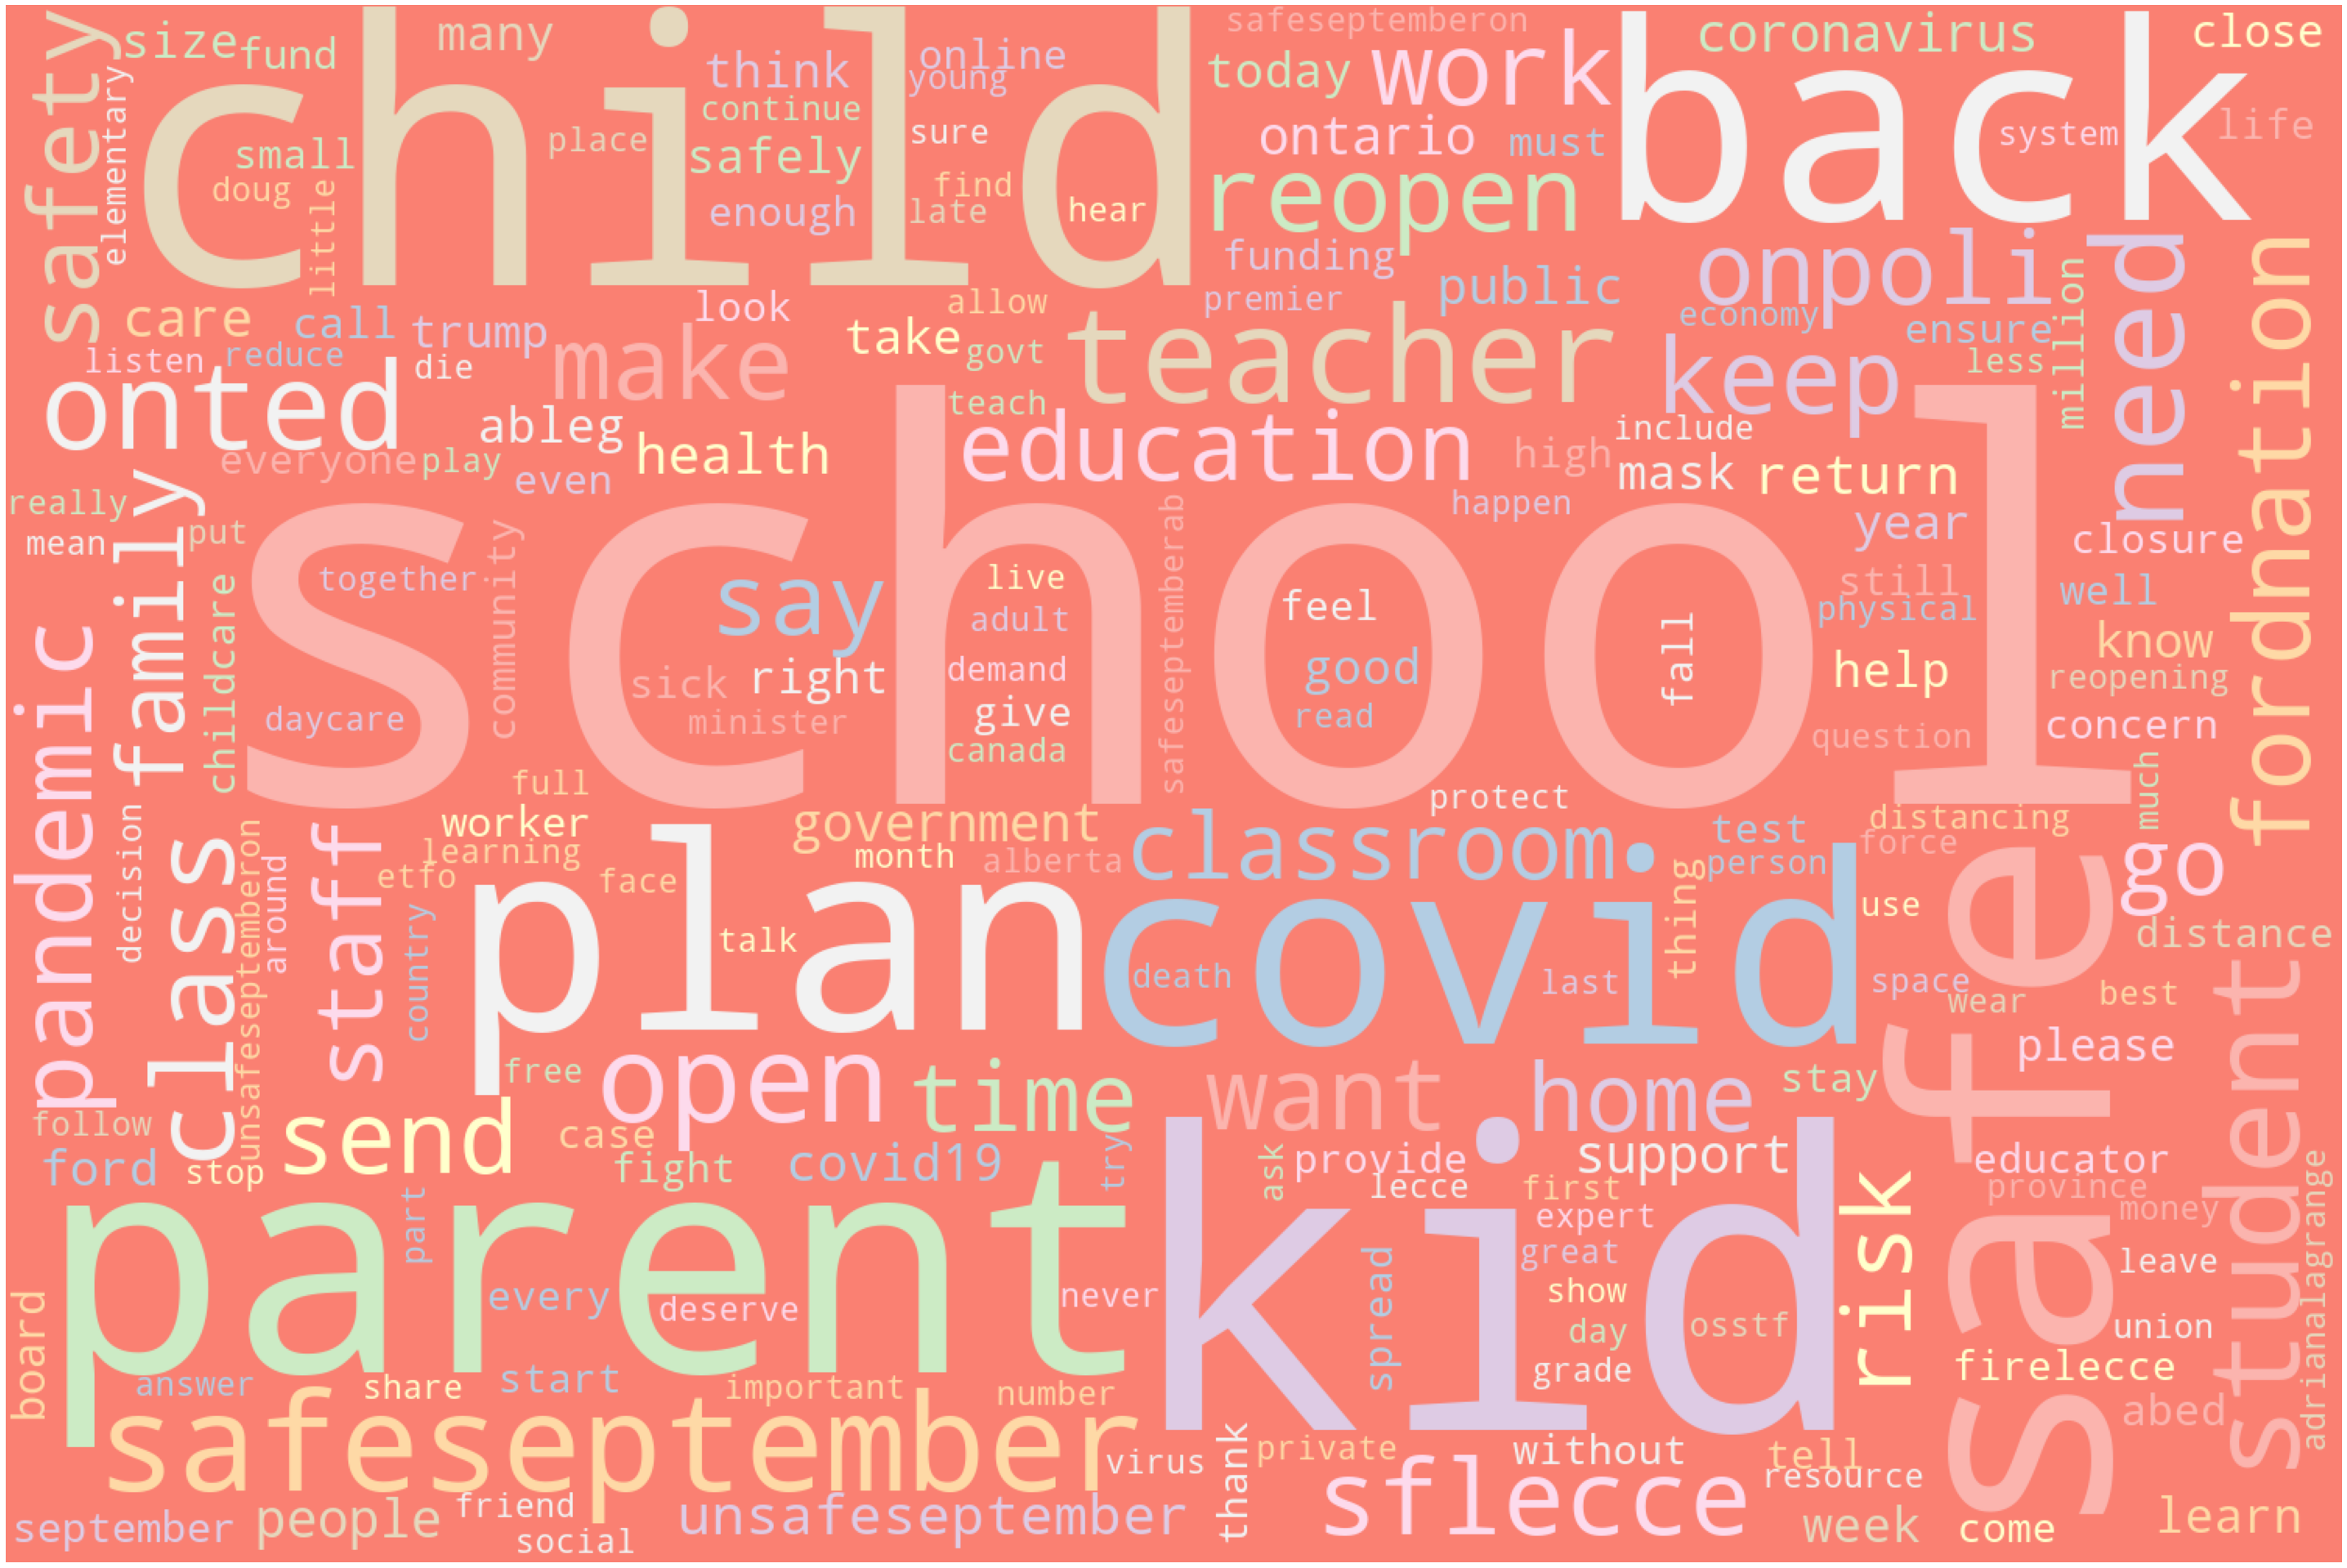

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

text = ' '.join(total_df[total_df.clean_text.notnull()]['clean_text'])
wordcloud = WordCloud(width=1500,
                      height=1000,
                      random_state=1,
                      background_color='salmon',
                      colormap='Pastel1',
                      collocations=False,
                      stopwords=STOPWORDS).generate(text)# Plot
# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");
plt.tight_layout()
# plt.savefig(f"../visualizations/content_analysis/{min_d}_{max_d}-wordcloud.png")

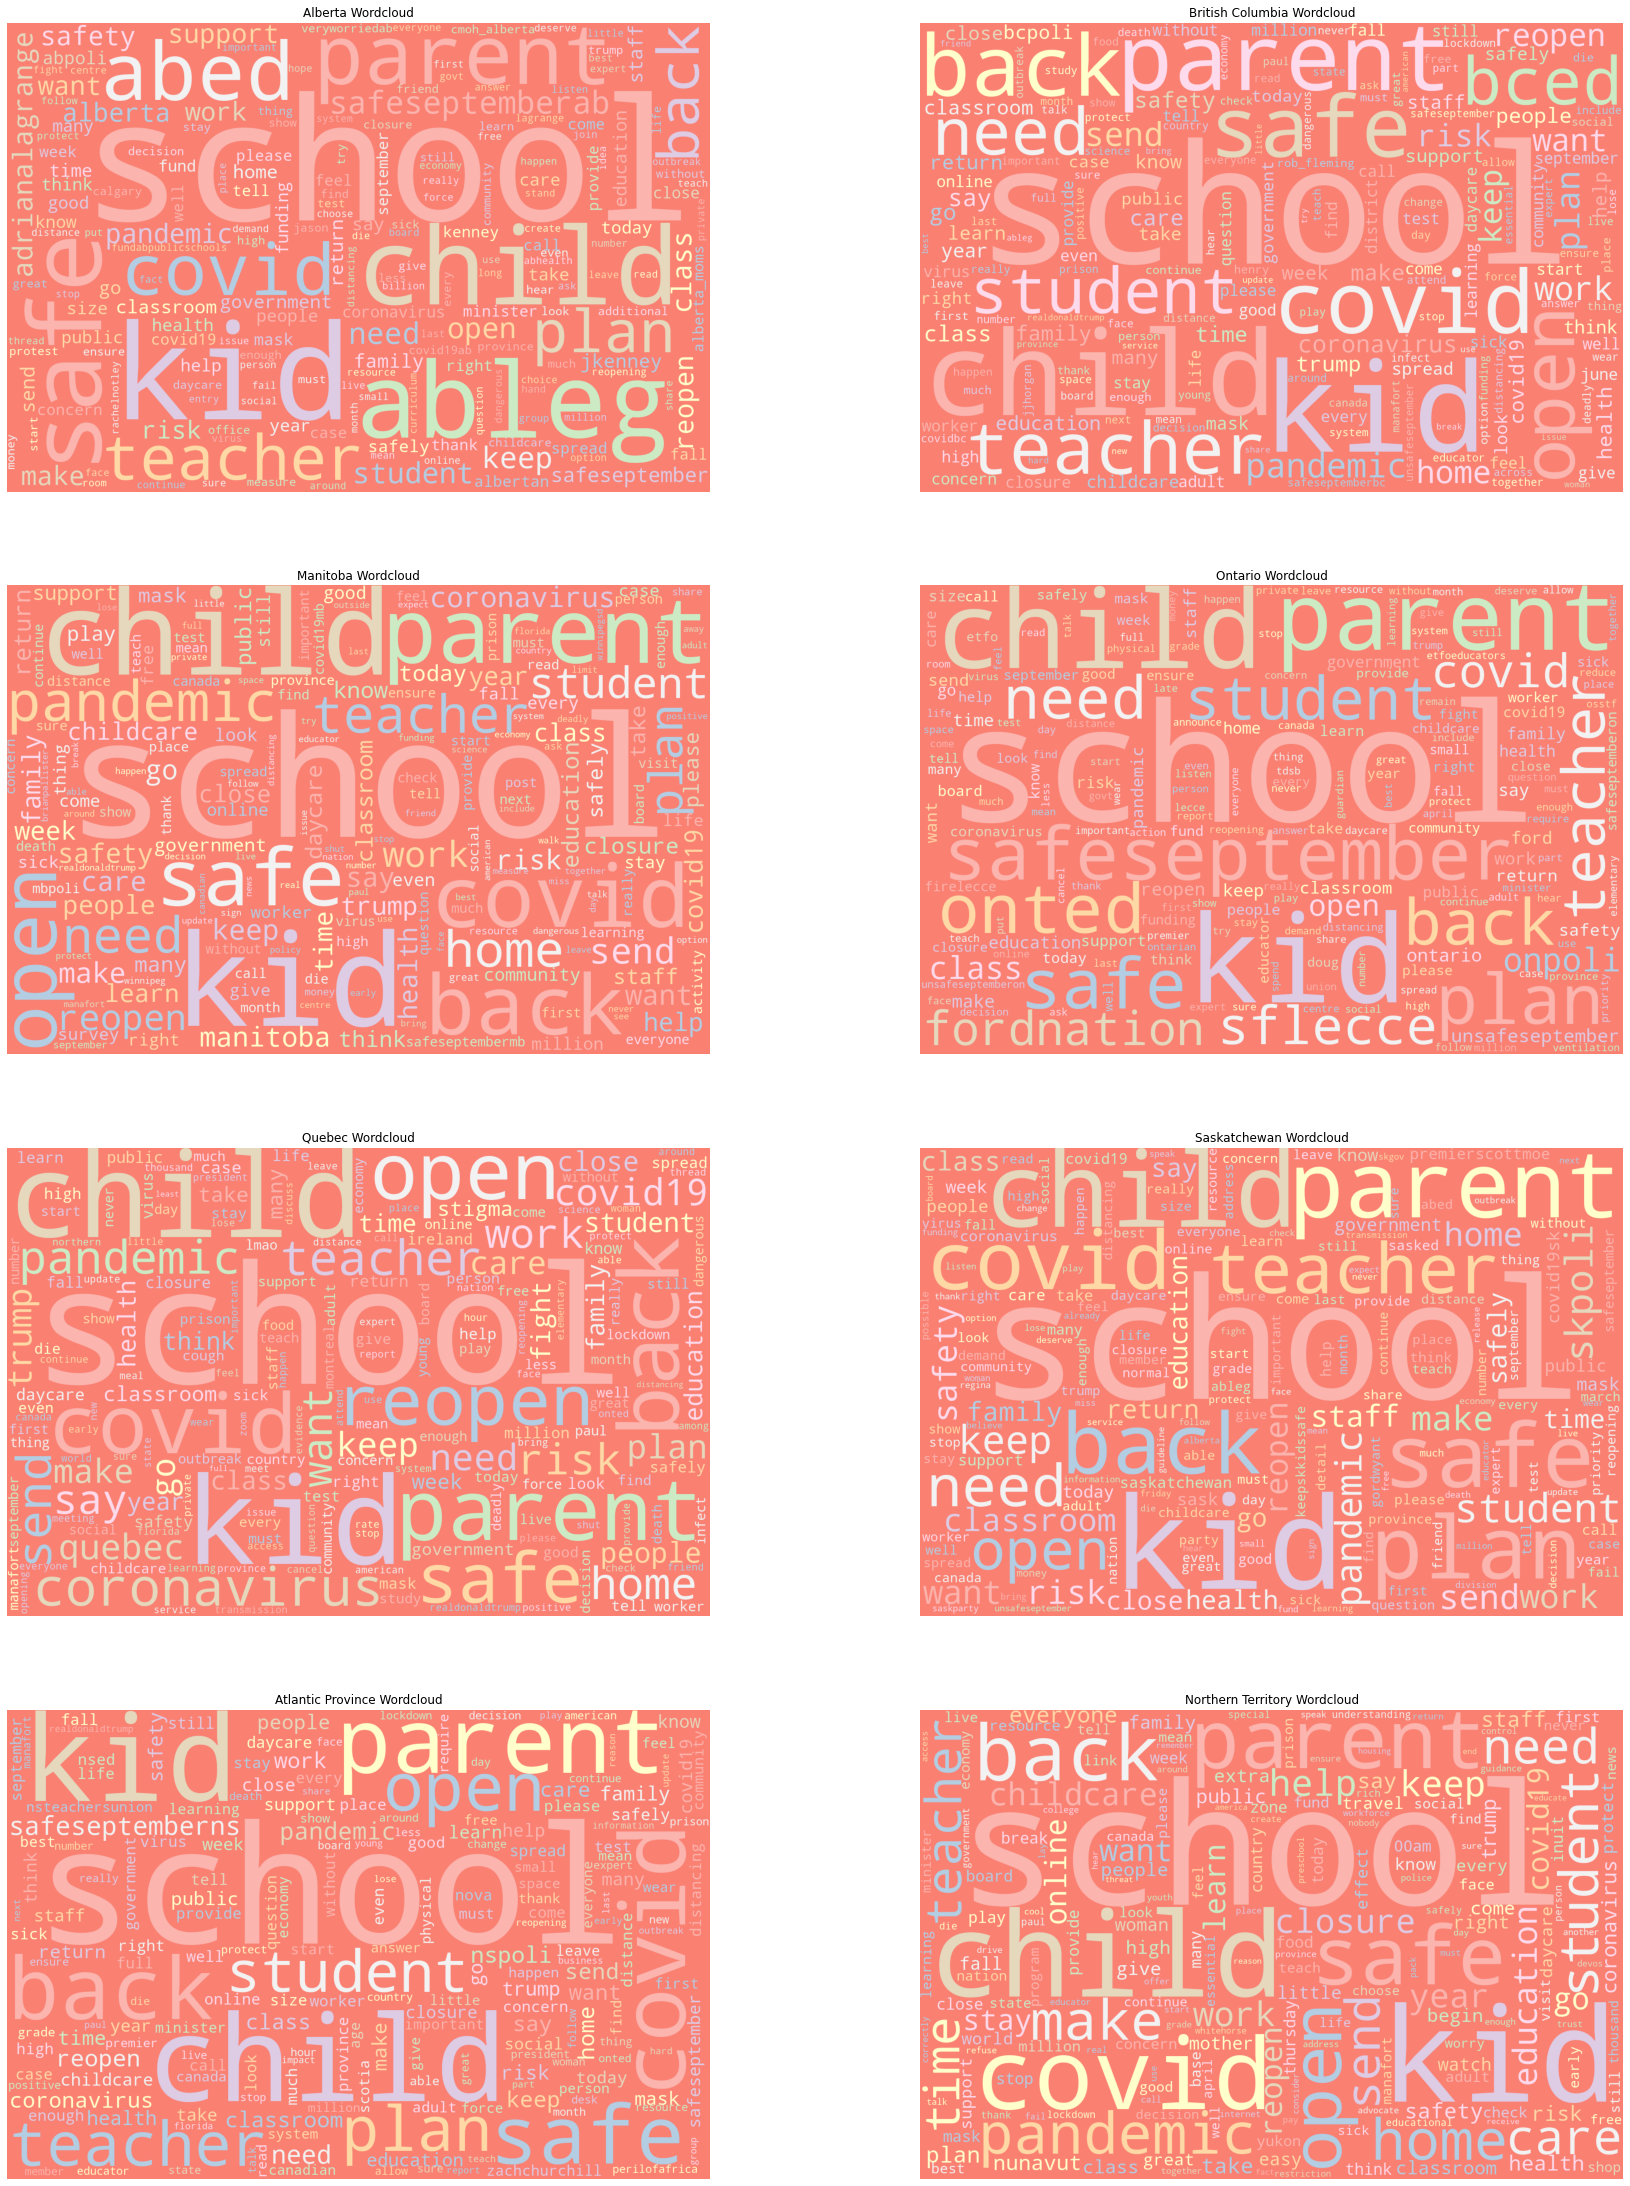

In [20]:
fig = plt.figure(figsize=(20,50))
for i,prov in enumerate(CONSOLIDATED_PROVINCES):
    ax = fig.add_subplot((len(CONSOLIDATED_PROVINCES)//2)+1,2,i+1)
    text = total_df[total_df.clean_text.notnull()]
    text = ' '.join(text[text["province"] == prov]["clean_text"])
    wordcloud = WordCloud(height=1000,
                          width=1500,
                          random_state=1,
                          background_color='salmon',
                          colormap='Pastel1',
                          collocations=False,
                          stopwords=STOPWORDS).generate(text)# Plot

    ax.imshow(wordcloud)
    ax.set_title(f"{prov} Wordcloud")
    ax.axis('off')